# Homework 06

In [231]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as hier

## Exercise 1: Clustering

First we prepare our dataframe. The source is `wine.data` with information about the dataset, for instance which attributes are present, from `wine.name`.

In [163]:
# first column is our class identifier (= target), the dataset has 3 number of instances for classification
columns = ['target', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

In [164]:
# import dataframe
df = pd.read_csv("../data/wine.data", names=columns)
df

,target,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [165]:
# check counts of each category
df['target'].value_counts()

2    71
1    59
3    48
Name: target, dtype: int64

### a) k-means
As a little help, we read through this article: https://grabngoinfo.com/5-ways-for-deciding-number-of-clusters-in-a-clustering-model/

In [228]:
# split df into data & class identifier labels
df_data = df[df.columns.difference(['target'])]
labels = df['target']

Before we can start with applying data, we need to standardize our data with a scaler, e.g. StandardScaler().

In [167]:
# preprocess data
X = StandardScaler().fit_transform(df_data)

For further visualization of the data we need to reduce our dimension size from 13 to a lower value. `PCA` allows us to project the data from the original space into a lower-dimensional space.

<AxesSubplot: xlabel='PCA1_2d', ylabel='PCA2_2d'>

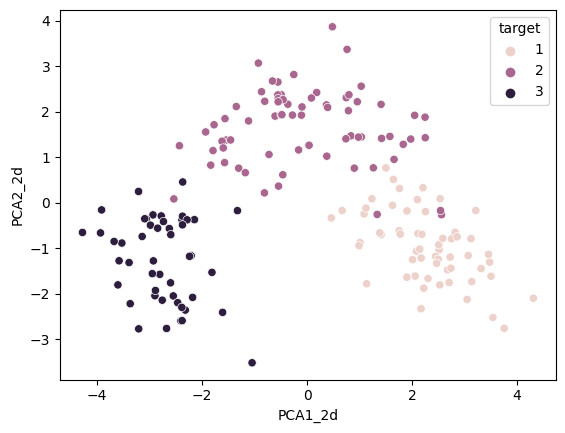

In [168]:
# n = 2
X_2n = PCA(n_components=2).fit_transform(X)

# add the two pca values to the original dataframe
df['PCA1_2d'] = X_2n[:, 0]
df['PCA2_2d'] = X_2n[:, 1]

# visualize 2-dimensional clustering
sns.scatterplot(data=df, x='PCA1_2d', y='PCA2_2d', hue='target')

In [169]:
# n = 3
X_3n = PCA(n_components=3).fit_transform(X)

# add the two pca values to the original dataframe
df['PCA1_3d'] = X_3n[:, 0]
df['PCA2_3d'] = X_3n[:, 1]
df['PCA3_3d'] = X_3n[:, 2]

# visualize the reduced features in a scatterplot
fig = px.scatter_3d(data_frame=df, x='PCA1_3d', y='PCA2_3d', z='PCA3_3d', color='target')
fig.show()

The scatter plots for $n_features = [2, 3]$ both indicate that we will have three cluster.

We need to apply three different approaches to determine the number of clusters and why we selected them:
- Elbow Curve
- Silhouette Analysis
- Hierarchical Graph
- Gap statistic -> not used, but would also be an option

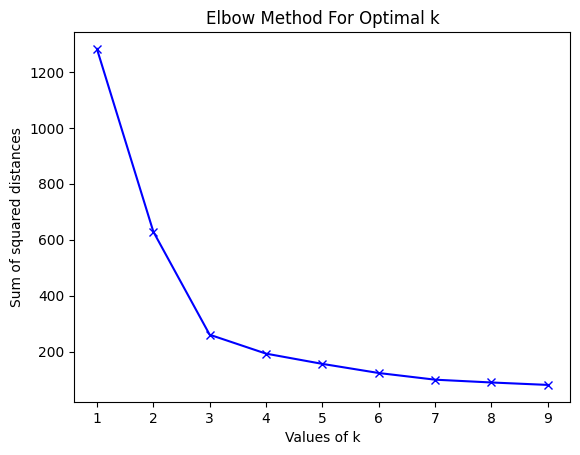

In [177]:
# elbow curve method
sum_of_squared_distances = []
cluster_range = range(1,10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_2n)
    # sum of squared distances of samples to their closest cluster center
    sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(cluster_range, sum_of_squared_distances, 'bx-')
plt.xlabel('Values of k') 
plt.ylabel('Sum of squared distances') 
plt.title('Elbow Method For Optimal k')

plt.show()

The plot does not really show a very clear result, but $k = 3$ indicates the biggest drop of sum of squared distances, which can be seen as the 'ellbow'. Since we are not sure if our assumption is correct, we will use the silhouette analysis as a next step for a more clear result.

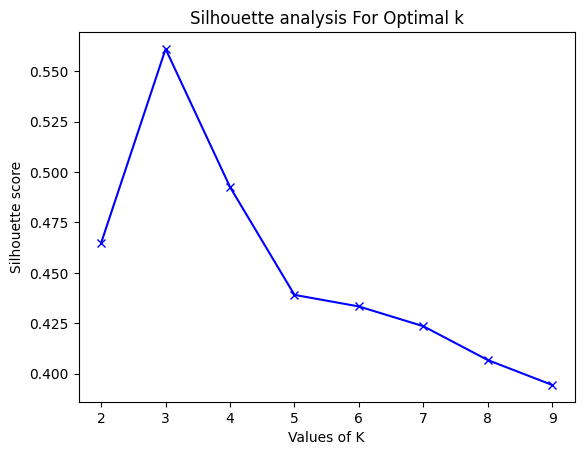

In [229]:
# silhouette analysis: data range [-1, 1]
silhouette_avg = []
cluster_range = [2, 3, 4, 5, 6, 7, 8, 9]

for k in cluster_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_2n)
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg.append(silhouette_score(X_2n, cluster_labels))

plt.plot(cluster_range, silhouette_avg, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

The silhouette plot has the best score at $k = 3$, which is the same value we picked from the ellbow graph. As a last step, we will have a look at the hierarchical graph.

Text(0, 0.5, 'Euclidean Distance')

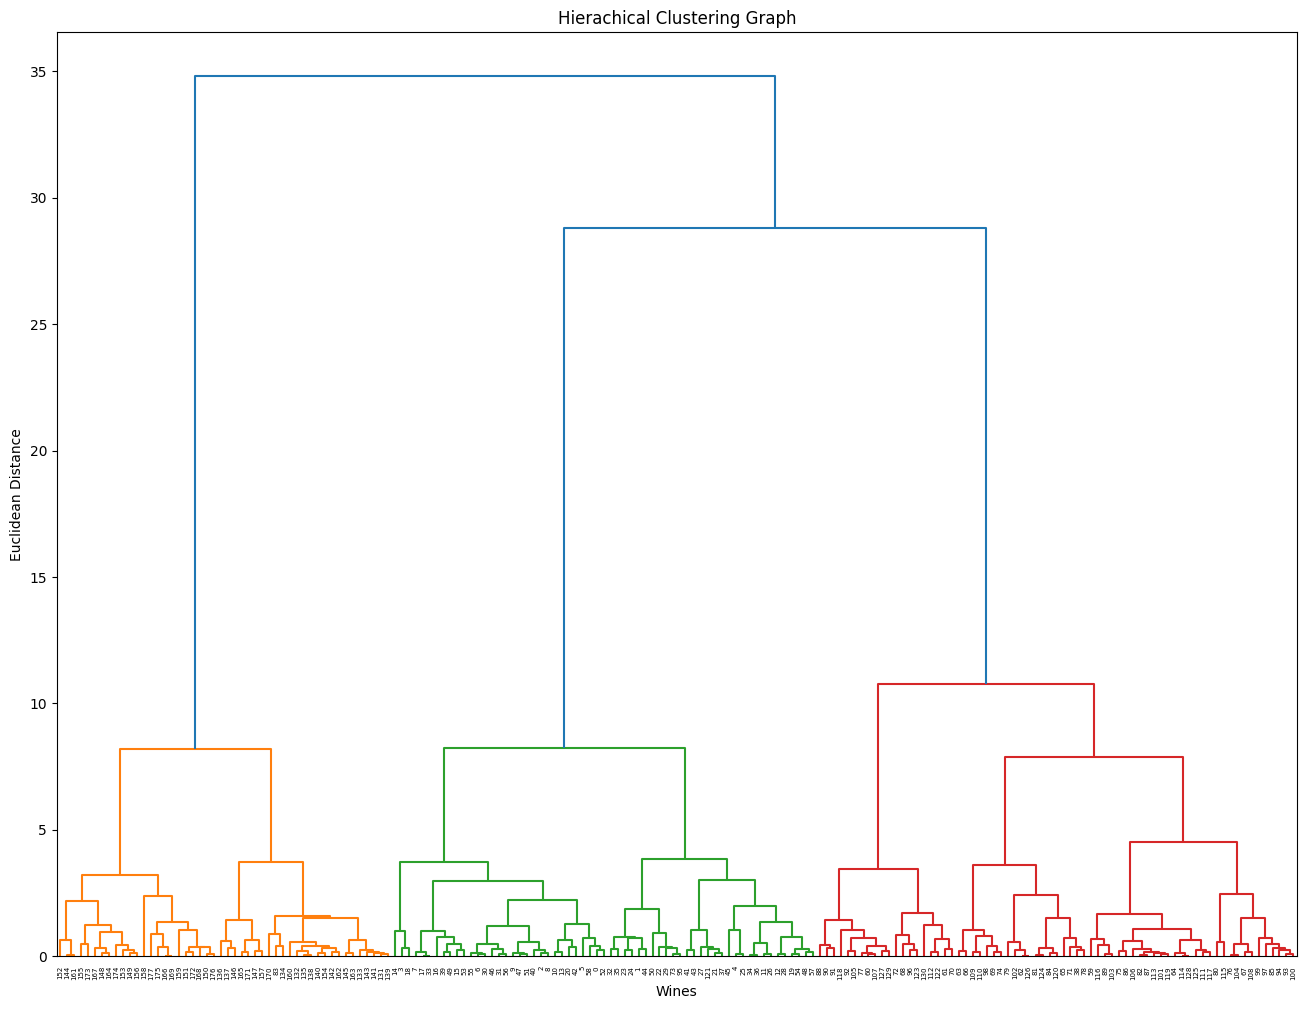

In [179]:
# hierarchical graph
plt.figure(figsize=(16,12))
heirachical_graph=hier.dendrogram(hier.linkage(X_2n, method='ward')) #method='ward' uses the Ward variance minimization algorithm

# Add titles and labels
plt.title('Hierachical Clustering Graph')
plt.xlabel('Wines')
plt.ylabel('Euclidean Distance')

The y axis is the euclidean distance, so the longer the vertical line is, the larger distance between the clusters. So, this graph shows, that $k = 3$ would be the optimal value for the number of clusters. This is again, the same value as the other methods that we used.

**Result**

After investigating different approaches we can now plot the k-means clustering with assumed $k = 3$ as the 'best' option.

### b) DBScan
Example from: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

parameters for `DBSCAN`:
- 'eps' = maximum distance between two points to still be considered in the same neighborhood
- 'min_samples' = number of samples in a neighborhood for a point to be considered as a core point

In [227]:
db = DBSCAN(eps=0.8, min_samples=5).fit(X_2n)

labels = db.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_2n, labels))

Estimated number of clusters: 2
Estimated number of noise points: 5
Silhouette Coefficient: 0.378


**Result**

Unfortunatly, we weren't able to reproduce the same results from k-means clustering. This could be due to small amount of data we have in the dataset because `DBSCAN` tries to cluster data points based on the input parameters, which are used to describe what points are considered to be the neighborhood of the current data point. With the amount of values we have, the parameters are very hard to set the parameters properly. This can result in bad clustering with noise points, which don't fit in either cluster group.

Another factor could be that our dataset is not 'dense' enough because otherwise the data points are spread too much, that the algorithm can not identify a neighborhood for the data points.

### c) evaluate clustering methods

In [230]:
# k-means with k = 3
kmeans = KMeans(n_clusters=3).fit(X_2n)
dbscan = DBSCAN(eps=0.8, min_samples=5).fit(X_2n)

Metrics to evaluate clustering models
- sum of squared errors: 
- purity: 
- Dunn index:
- Davies Bouldin Index: The minimum score is zero, with lower values indicating better clustering

In [ ]:
# sum of squared errors

In [232]:
# davies bouldin index as 'davies_bouldin_score'
print(f"Davies bouldin score: \n kmeans = {davies_bouldin_score(X_2n, kmeans.labels_)} \n dbscan = {davies_bouldin_score(X_2n, dbscan.labels_)}")

Davies bouldin score: 
 kmeans = 0.5972661544221365 
 dbscan = 4.281726344469725
